=== Robust Regression ===
                    Robust linear Model Regression Results                    
Dep. Variable:          total_penalty   No. Observations:                   23
Model:                            RLM   Df Residuals:                       19
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 15 Oct 2025                                         
Time:                        21:46:24                                         
No. Iterations:                     2                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

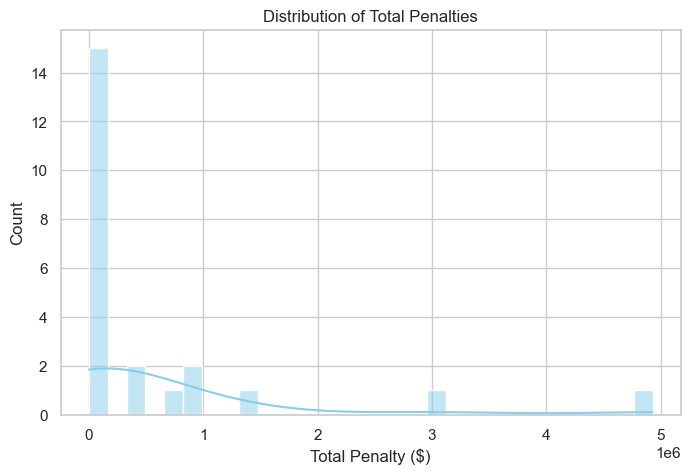

C:\Users\reyno\AppData\Local\Temp\ipykernel_6388\136302428.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Case_Type', y='total_penalty', data=df_melt, palette="Set2")


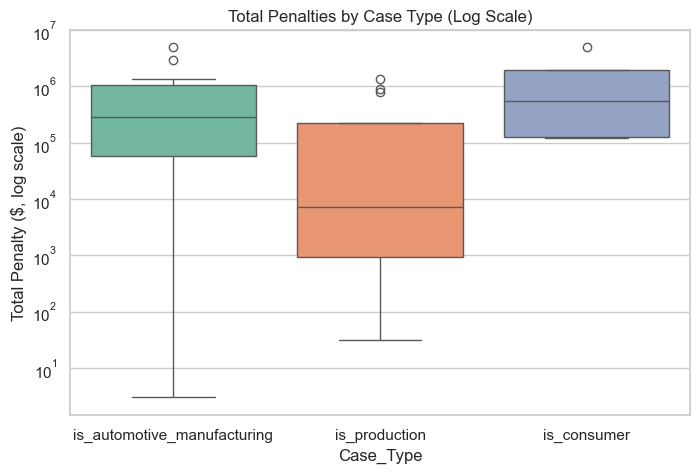

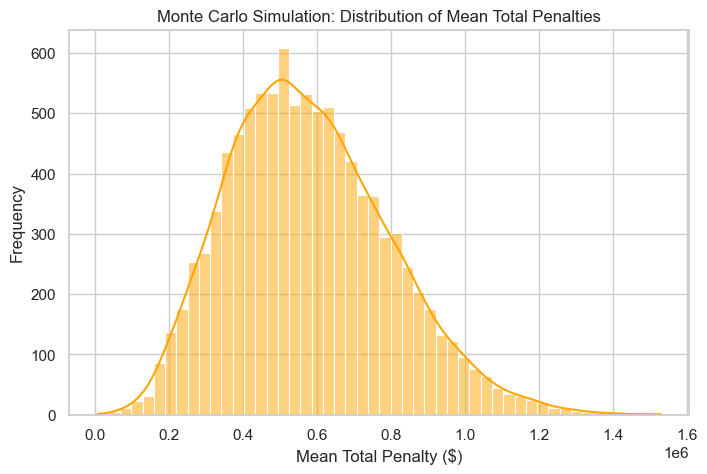


=== Summary ===
1. Robust regression shows how each case type contributes to total penalties.
2. Monte Carlo simulation estimates the mean penalty per case with a 95% confidence interval.
3. T-test compares automotive vs non-automotive penalties for statistical significance.
4. Histograms show the overall distribution of penalties, with boxplots by case type.
5. Log scale is used in boxplots to handle large differences in penalty amounts.


In [ ]:
import requests
import re
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor

API_KEY = "4c700d399bfe02685f6d4b2fa57e540046c3d03b"
SEARCH_KEYWORDS = "automotive data breach"
OUTPUT_CSV = "lawsuit_data_leakages.csv"
RESULTS_PER_PAGE = 25  # max allowed
MAX_WORKERS = 5
SLEEP_BETWEEN_REQUESTS = 1  # per robots.txt

HEADERS = {
    "Authorization": f"Token {API_KEY}"
}


def search_courtlistener_v4(query, page_url=None):
    url = page_url if page_url else "https://www.courtlistener.com/api/rest/v4/opinions/"
    params = None if page_url else {"search": query, "page_size": RESULTS_PER_PAGE}

    try:
        resp = requests.get(url, params=params, headers=HEADERS)
        if resp.status_code == 429:  # throttled
            print("Throttled. Sleeping 1800s...")
            time.sleep(1800)
            return search_courtlistener_v4(query, page_url)
        elif resp.status_code == 401:
            print("Unauthorized! Check your API key.")
            return None
        resp.raise_for_status()
        return resp.json()
    except Exception as e:
        print("Error fetching page:", e)
        return None


def download_case_text(resource_uri):
    if not resource_uri.startswith("http"):
        resource_uri = "https://www.courtlistener.com" + resource_uri
    resp = requests.get(resource_uri, headers=HEADERS)
    if resp.status_code == 200:
        data = resp.json()
        return data.get("plain_text", "")
    return ""


def fetch_cluster_name(cluster_url):
    if not cluster_url:
        return "Unknown"
    resp = requests.get(cluster_url, headers=HEADERS)
    if resp.status_code == 200:
        cluster_data = resp.json()
        return cluster_data.get("caseName", "Unknown")
    return "Unknown"


def extract_penalty_and_reason(text):
    penalties = []
    reasons = []

    # Extract monetary amounts
    amount_pattern = r"\$\s?\d{1,3}(?:,\d{3})*(?:\.\d{2})?"
    amounts = re.findall(amount_pattern, text)
    amounts_clean = []
    for amt in amounts:
        cleaned = amt.replace("$", "").replace(",", "").strip()
        try:
            amounts_clean.append(float(cleaned))
        except ValueError:
            continue
    if amounts_clean:
        total_amount = sum(amounts_clean)
        penalties.append("${:,.2f}".format(total_amount))

    # Extract reasons independently of penalties
    lowered_text = text.lower()
    if "consumer" in lowered_text:
        reasons.append("consumer data")
    if "production" in lowered_text or "manufacturing" in lowered_text:
        reasons.append("production data")
    if "automotive" in lowered_text:
        reasons.append("automotive manufacturing")
    if not reasons:
        reasons.append("unspecified")

    return penalties, reasons


results = []
page_url = None

while True:
    data = search_courtlistener_v4(SEARCH_KEYWORDS, page_url)

    if not data or "results" not in data:
        print("No results found or end of pages.")
        break

    if not isinstance(data["results"], list):
        print("Unexpected results type:", type(data["results"]))
        break

    def process_case(case):
        if not isinstance(case, dict):
            return None

        cluster_url = case.get("cluster")
        case_name = fetch_cluster_name(cluster_url) if isinstance(cluster_url, str) else "Unknown"

        resource_uri = case.get("resource_uri", "")
        court_date = case.get("dateFiled") or case.get("date_filed") or ""
        case_url = case.get("absolute_url", "")

        if not resource_uri:
            return None

        text = download_case_text(resource_uri)
        if not text:
            return None

        penalties, reasons = extract_penalty_and_reason(text)

        # Debug print to see what's being captured
        print(f"Case: {case_name}, Penalties: {penalties}, Reasons: {reasons}")

        # Filter only relevant cases
        if not any(reason in reasons for reason in ["automotive manufacturing", "production data"]):
            return None

        return {
            "case_name": case_name,
            "case_url": "https://www.courtlistener.com" + case_url,
            "date": court_date,
            "penalty_amounts": ", ".join(penalties),
            "penalty_reason": ", ".join(reasons)
        }

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        processed_cases = list(executor.map(process_case, data["results"]))

    # Filter out None
    processed_cases = [c for c in processed_cases if c]
    results.extend(processed_cases)

    # Pagination
    page_url = data.get("next")
    if not page_url:
        break

    time.sleep(SLEEP_BETWEEN_REQUESTS)

# Save results to CSV
if results:
    df = pd.DataFrame(results)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Scraping complete. Results saved to {OUTPUT_CSV}")
else:
    print("No relevant automotive manufacturing cases found.")
